In [1]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy import signal
import zipfile
from scipy.stats import mode
from scipy.signal import savgol_filter
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LinearRegression
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor

D:\python\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
path = 'D:/PD_project'
patient_markup_path = '/'.join([path, 'patients.xlsx'])
folder_name = 'ex6_book'
points_path = '/'.join([path, folder_name])
points_path_arch = points_path + '_arch'
additional_path = '/'.join(['content/drive/My Drive/tremor recognition/output/json', folder_name])

In [4]:
FEATURE_TYPE = 'pose_keypoints_2d'
#necessary points:
#    -left_hand: 5, 6, 7
#    -right hand: 2, 3, 4
#    -head: 0

### Upload targets

In [5]:
patient_markup = pd.read_excel(patient_markup_path)
patient_markup.dropna(subset=['is_bradykinesia'], inplace=True)

In [6]:
considered_patients = []
for file in os.listdir(points_path_arch):
#     print(file)
    p_num = int(file.split('.')[0].split('_')[0][-2:])
    if p_num in patient_markup.num.values:
        considered_patients.append(patient_markup.values[patient_markup.num.values == p_num])

In [7]:
num_of_patients = len(considered_patients)
num_of_patients

32

In [8]:
considered_patients = np.array(considered_patients).reshape(num_of_patients, -1)
considered_patients = pd.DataFrame(considered_patients[:,(0,-3)])

In [9]:
considered_patients.columns = ['num', 'is_bradykinesia']
considered_patients = considered_patients.astype('int') 

In [10]:
# for file in os.listdir(points_path_arch):
#     arch_path = '/'.join([points_path_arch, file])
#     folder_path = '/'.join([points_path, file.split('.')[0]])
#     arch = zipfile.ZipFile(arch_path, 'r')
#     os.system('mkdir '+folder_path)
#     arch.extractall(folder_path)

### Some useful functions

In [11]:
def zero_fill(arr):
    '''
    fill gaps in data by extrapolation
    
    '''
#     print(np.sum(arr!=0))
    if np.sum(arr!=0) < 2:
        return arr
    x = np.arange(len(arr))
    arr_no_0 = arr[arr!=0]
#     print(arr.shape)
    interp = interp1d(x[arr!=0], arr_no_0, fill_value="extrapolate")
    fill = interp(x[arr==0])
    arr[arr==0] = fill
    return arr

In [12]:
def smooth_savgol(signal):
    '''
    make signal smoother
    
    '''
    signal_len = len(signal)
    window_length = 19
    polyorder = 4
    return savgol_filter(signal, 
                           window_length = window_length, 
                           polyorder=polyorder)

In [13]:
def get_coord(folder_path, feature_type):
    '''
    return an array of coordinates corresponding to <feature_type>
    for all people detected by the algorithm;
    json files are obtained from the <folder_path>

    '''
    
    coords = {}
    
    file_path = '/'.join([folder_path, additional_path, folder_path.split('/')[-1]])
    
    for file in os.listdir(file_path):
        with open('/'.join([file_path, file]), "r") as read_file:
            data = json.load(read_file)['people']
        for i, person in enumerate(data):
            # openpose does not provide an option to distinguish people,
            # therefore for that purpose head displacement was observed 
            # (here errors might arise due to incorrect functioning of the openpose library)

            head_coords = np.array(person['pose_keypoints_2d'][:2])
            if i not in coords.keys():
                coords[i] = {'head': [head_coords], 
                             'coords_x': [person[feature_type][::3]],
                             'coords_y': [person[feature_type][1::3]],
                             'conf': [person[feature_type][2::3]]
                            }
            else:
                pr_i = None
                min_i = 1e100
                for j in coords.keys():
                    if np.linalg.norm(head_coords-coords[j]['head'][-1]) < min_i:
                        min_i = np.linalg.norm(head_coords-coords[j]['head'][-1])
                        pr_i = j
                coords[pr_i]['head'].append(head_coords)
                for k, key in enumerate(['coords_x', 'coords_y', 'conf']):
                    coords[pr_i][key].append(person[feature_type][k::3])
#                 coords[pr_i]['coords_x'].append(person[feature_type][::3])
#                 coords[pr_i]['coords_y'].append(person[feature_type][1::3])
#                 coords[pr_i]['conf'].append(person[feature_type][2::3])
    for i in coords.keys():
        coords[i]['head'] = np.array(coords[i]['head'])
        for k in ['coords_x', 'coords_y', 'conf']:
            coords[i][k] = np.array(coords[i][k])
    return coords

In [14]:
def get_hand_diffs(arr):
    '''
    return speeds and accelerations of changes in distances between keypoints 
    2, 3, 4 of the right hand
    from the coordinates array <arr> (corresponds to 'pose_keypoints_2d') 
    
    '''
#     res_coords = (arr[:, (4, 4, 3, 7, 7, 6)] - arr[:, (2, 3, 2, 5, 6, 5)]).T
    res_coords = (arr[:, (4, 4, 3)] - arr[:, (2, 3, 2)]).T
    for i in range(len(res_coords)):
        res_coords[i] = smooth_savgol(zero_fill(res_coords[i]))
    res_coords = res_coords.T
    res_vs = (res_coords - np.roll(res_coords, 1, axis=0))[1:]
    res_as = (res_vs - np.roll(res_vs, 1, axis=0))[1:]
    return res_vs, res_as

In [15]:
def get_features(coords): #for one person
    '''
    create features from the coordinates values:
    mean, std and mode for speeds and accelerations of coordinates changes

    '''
    res_vs_x, res_as_x = get_hand_diffs(coords['coords_x'])
    res_vs_y, res_as_y = get_hand_diffs(coords['coords_y'])
    means = np.append([np.mean(res_vs_x, axis=0), np.mean(res_vs_y, axis=0)], 
                      [np.mean(res_as_x, axis=0), np.mean(res_as_y, axis=0)]
                     )
    stds = np.append([np.std(res_vs_x, axis=0), np.std(res_vs_y, axis=0)],
                     [np.std(res_as_x, axis=0), np.std(res_as_y, axis=0)]
                    )
#     maxs - dangerous because of noise
#     noise can be decreased by tuning open pose detection
#     maxs = np.append([np.amax(res_vs_x, axis=0), np.amax(res_vs_y, axis=0)],
#                      [np.amax(res_as_x, axis=0), np.amax(res_as_y, axis=0)]
#                     )
#     mins = np.append([np.amin(res_vs_x, axis=0), np.amin(res_vs_y, axis=0)],
#                      [np.amin(res_as_x, axis=0), np.amin(res_as_y, axis=0)]
#                     )
#     mins - stupid cause patients can just seat
#     to avoid this situation the periodic part corresponding to implementing 
#     of the exercise should be cut from the whole time series
    mods = np.append([mode(res_vs_x, axis=0)[0], mode(res_vs_y, axis=0)[0]],
                     [mode(res_as_x, axis=0)[0], mode(res_as_y, axis=0)[0]]
                    )
    return means, stds, mods

In [16]:
def create_dataset(points_path, considered_patients):
    data = []
    for folder_name in os.listdir(points_path):
        p_num = int(folder_name.split('.')[0].split('_')[0][-2:])
        if p_num in considered_patients.num.values:
            folder_path = '/'.join([points_path, folder_name])
            coords = get_coord(folder_path, FEATURE_TYPE)
            patient = 0
#             here is the heuristic method of finding the person
#             who is doing exercices (it should be done more accurate)

            if len(coords.keys()) > 1:
                head_means_y = [] #consider y axis
                head_means_x = []
                keys = []
                lens = []
                for k in coords.keys():
                    lens.append(len(coords[k]['head']))
                    head_means_y.append(np.mean(coords[k]['head'][:, 1]))
                    head_means_x.append(np.mean(coords[k]['head'][:, 0]))
                    keys.append(k)
                keys = np.array(keys)
                head_means_x = np.array(head_means_x)
                head_means_y = np.array(head_means_y)
                keys = keys[np.argsort(lens)[-2:]]
                head_means_y = head_means_y[np.argsort(lens)[-2:]]
                patient = keys[np.argmax(head_means_y)]
            means, stds, mods = get_features(coords[patient])
            y = considered_patients.is_bradykinesia.values[considered_patients.num.values == p_num][0]
            l = np.append(np.append([means, stds], mods), np.array([y, p_num]))
            data.append(l)
        print(folder_name, 'done')
    columns = []
    for n in ['mean', 'std', 'mode']:
        for i in range(12):
            columns.append(n+'_'+str(i))
    columns.append('target')
    columns.append('patient_num')
    data = pd.DataFrame(data, columns=columns)
    data['target'] = data['target'].astype('int')
    data['patient_num'] = data['patient_num'].astype('int')
    return data

In [17]:
def get_grid(data):
    '''
    function for visualisation
    
    '''
    x_min, x_max = data[:, 0].min() - 10, data[:, 0].max() + 10
    y_min, y_max = data[:, 1].min() - 10, data[:, 1].max() + 10
    return np.meshgrid(
        np.arange(x_min, x_max, 1),
        np.arange(y_min, y_max, 1),
    )

### Get data

In [18]:
data = create_dataset(points_path, considered_patients)

patient03_03_ex6_2019-01-24 done
patient05_05_2_ex6_2019-01-24 done
patient06_06_2_ex6_2019-01-24 done
patient06_06_ex6_2019-01-24 done
patient08_08_ex6_2019-01-25 done
patient11_11_ex6_2019-01-25 done
patient22_22_ex6_2019-01-31 done
patient23_23_2_ex6_2019-01-31 done
patient23_23_ex6_2019-01-31 done
patient27_27_ex6_2019-02-07 done
patient29_29_ex6_2019-02-12 done
patient30_30_ex6_2019-02-12 done
patient31_31_ex6_2019-02-12 done
patient32_32_2_ex6_2019-02-12 done
patient32_32_ex6_2019-02-12 done
patient33_33_2_ex6_2019-02-12 done
patient33_33_ex6_2019-02-12 done
patient39_39_ex6_2019-02-26 done
patient40_40_ex6_2019-02-26 done
patient41_41_2_ex6_2019-02-28 done
patient42_42_2_ex6_2019-02-28 done
patient42_42_ex6_2019-02-28 done
patient43_43_2_ex6_2019-02-28 done
patient43_43_ex6_2019-02-28 done
patient49_49_ex7_2019-03-28 done
patient50_50_ex6_2019-03-28 done
patient51_51_ex6_2019-04-09 done
patient52_52_ex7_2019-04-09 done
patient53_53_2_ex6_2019-04-11 done
patient54_54_2_ex6_2019-0

In [19]:
X = data.values[:,:-2]
y = data.target.values

### How well data is clustered

In [20]:
kmeans = KMeans(n_clusters=2, random_state=8).fit(X)
print(round(accuracy_score(kmeans.labels_, y), 4) * 100, '%')

78.12 %


### Data augmentation

In [21]:
sm = SMOTE(random_state=42, k_neighbors=3, sampling_strategy={0: 200, 1:200})

X_sm, y_sm = sm.fit_resample(X, y)

D:\python\lib\site-packages\imblearn\utils\_validation.py:253: UserWarning: After over-sampling, the number of samples (200) in class 0 will be larger than the number of samples in the majority class (class #1 -> 19)
  n_samples_majority))
D:\python\lib\site-packages\imblearn\utils\_validation.py:253: UserWarning: After over-sampling, the number of samples (200) in class 1 will be larger than the number of samples in the majority class (class #1 -> 19)
  n_samples_majority))


### Learn model to receive probabilities

In [22]:
lr = LogisticRegression(n_jobs=4)

In [23]:
lr.fit(X_sm, y_sm)

D:\python\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\python\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=4, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

### Get TSNE-model and get 2D-data

In [24]:
lr_tsne = LinearRegression(n_jobs=4)
tree_tsne = DecisionTreeRegressor(random_state=42)

In [25]:
tsne = TSNE(n_components=2, verbose=1, perplexity=6, random_state=3)
tsne_results = tsne.fit_transform(X_sm)

[t-SNE] Computing 19 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.001s...
[t-SNE] Computed neighbors for 400 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 1.513334
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.137543
[t-SNE] KL divergence after 1000 iterations: 0.246750


In [26]:
lr_2d = LogisticRegression(random_state=42, n_jobs=4)
lr_2d.fit(tsne_results, y_sm)

D:\python\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\python\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=4, penalty='l2', random_state=42,
                   solver='warn', tol=0.0001, verbose=0, warm_start=False)

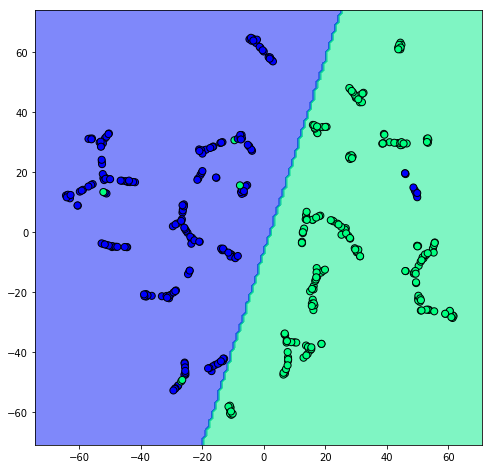

In [27]:
xx, yy = get_grid(tsne_results)
predicted = lr_2d.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.figure(figsize=(8, 8))
plt.contourf(xx, yy, predicted, cmap='winter', alpha=0.5)
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_sm, s=50, cmap='winter', edgecolor='k')

In [28]:
lr_tsne.fit(X_sm, tsne_results)
tree_tsne.fit(X_sm, tsne_results)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

## Get test_data

In [83]:
path = 'D:/PD_project'
folder_name = 'Tamara'
points_path = '/'.join([path, folder_name])
points_path_arch = points_path + '_arch'
additional_path = '/'.join(['content/drive/My Drive/tremor recognition/output/json', folder_name])

#### Get data

In [84]:
test_data = []
for folder_name in os.listdir(points_path):
    folder_path = '/'.join([points_path, folder_name])
    coords = get_coord(folder_path, FEATURE_TYPE)
    patient = 0
    if len(coords.keys()) > 1:
        lens = []
        keys = []
        for k in coords.keys():
            lens.append(len(coords[k]['head']))
            keys.append(k)
        patient = keys[np.argmax(lens)]
    means, stds, mods = get_features(coords[patient])
    l = np.append(np.append([means, stds], mods), np.array([2]))
    test_data.append(l)
columns = []
for n in ['mean', 'std', 'mode']:
    for i in range(12):
        columns.append(n+'_'+str(i))
columns.append('target')
test_data = pd.DataFrame(test_data, columns=columns)
test_data['target'] = test_data['target'].astype('int')

In [85]:
X_test = test_data.values[:,:-1]
y_test = test_data.values[:,-1]

#### Predict probability of having PD

In [94]:
probas = lr.predict_proba(X_test)
print("Patient", i, 'is health with probability =', round(probas[1][0], 2), 
      'and ill with probability = ', round(probas[1][1], 2))

Patient 0 is health with probability = 0.99 and ill with probability =  0.01


In [87]:
lr.predict(X_test)

array([0, 0])

#### Find a patient's point on the graph

In [88]:
X_test_2d = tree_tsne.predict(X_test)

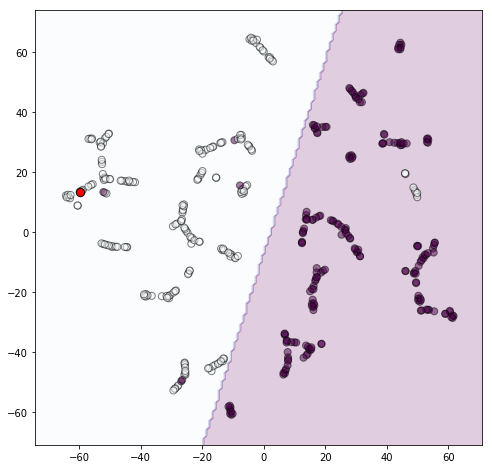

In [89]:
xx, yy = get_grid(tsne_results)
predicted = lr_2d.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.figure(figsize=(8, 8))
plt.contourf(xx, yy, predicted, cmap='BuPu', alpha=0.2)
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_sm, s=50, cmap='BuPu', edgecolor='k', alpha=0.5)

plt.scatter(X_test_2d[0,0], X_test_2d[0,1], color='r', edgecolor='k', s=70)
# plt.scatter(X_test_2d[1,0], X_test_2d[1,1], color='r')
plt.show()